In [1]:
import os
import sys
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import glob
import math
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import RandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import albumentations
from efficientnet_pytorch import model as enet
from fastprogress.fastprogress import master_bar, progress_bar
device = torch.device('cuda:2')
# torch.cuda.set_device(device)
# import apex; from apex import amp

In [2]:
kernel_type = 'effnet-b6-unseen'
enet_type = 'efficientnet-b6'
fold = 0
HEIGHT = 137
WIDTH = 236
image_size = 224
cut_size = int(image_size * 0.85)
data_dir = 'bengali'
batch_size = 64
num_workers = 32
init_lr = 0.001
c0_dim = 1295
c1_dim = 168
c2_dim = 11
c3_dim = 7
out_dim = c0_dim + c1_dim + c2_dim + c3_dim
loss_weight = [4, 2, 1, 1]
n_epochs = 60
use_amp = False

files_train = [f'bengaliai-cv19-feather/train_image_data_{fid}.feather' for fid in range(4)]
files_test = [f'bengaliai-cv19-feather/test_image_data_{fid}.feather' for fid in range(4)]

df_train = pd.read_csv(os.path.join(data_dir, f'train.csv'))
df_class_map = pd.read_csv(os.path.join(data_dir, f'class_map.csv'))

id2grapheme = {i: grapheme for i, grapheme in enumerate(df_train.grapheme.unique())}
grapheme2id = {grapheme: i for i, grapheme in enumerate(df_train.grapheme.unique())}
df_train['grapheme_id'] = df_train['grapheme'].map(grapheme2id)

n_fold = 5
skf = StratifiedKFold(n_fold, random_state=42)
for i_fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train.grapheme)):
    df_train.loc[val_idx, 'fold'] = i_fold
df_train['fold'] = df_train['fold'].astype(int)

df_label_map = []
for i, df in progress_bar(df_train.groupby('grapheme_id')):
    df_label_map.append(df.iloc[:, 1:6].drop_duplicates())
df_label_map = pd.concat(df_label_map).reset_index(drop=True)

/home/pengfei/miniconda3/envs/xray/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [3]:
def read_data(files):
    tmp = []
    for f in files:
        F = os.path.join(data_dir, f)
        data = pd.read_feather(F)
        res = data.iloc[:, 1:].values
        imgs = []
        for i in progress_bar(range(res.shape[0])):
            img = res[i].squeeze().reshape(HEIGHT, WIDTH)
            img = cv2.resize(img, (128, 128))
            imgs.append(img)
        imgs = np.asarray(imgs)
        
        tmp.append(imgs)
    tmp = np.concatenate(tmp, 0)
    return tmp


class BengaliDataset(Dataset):
    def __init__(self, csv, data, idx, split, mode, transform=None):

        self.csv = csv.reset_index()
        self.data = data
        self.idx = np.asarray(idx)
        self.split = split
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.idx.shape[0]

    def __getitem__(self, index):
        index = self.idx[index]
        this_img_id = self.csv.iloc[index].image_id
        
        image = self.data[index]
        image = 255 - image

        if self.transform is not None:
            image_origin = image.astype(np.float32).copy()
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image_origin = image.astype(np.float32).copy()
            image = image.astype(np.float32)

        image /= 255
        image = image[np.newaxis, :, :]
        image = np.repeat(image, 3, 0)  # 1ch to 3ch
        ###
        image_origin /= 255
        image_origin = image_origin[np.newaxis, :, :]
        image_origin = np.repeat(image_origin, 3, 0)  # 1ch to 3ch
        ###

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            label_0 = self.csv.iloc[index].grapheme_id
            label_1 = self.csv.iloc[index].grapheme_root
            label_2 = self.csv.iloc[index].vowel_diacritic
            label_3 = self.csv.iloc[index].consonant_diacritic
            label = [label_0, label_1, label_2, label_3]
            return torch.tensor(image), torch.tensor(image_origin), torch.tensor(label)

In [4]:
data = read_data(files_train)
transforms_train = albumentations.Compose([
    albumentations.RandomBrightness(limit=0.2, p=0.75),
    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=5),
        albumentations.MedianBlur(blur_limit=5),
        albumentations.GaussianBlur(blur_limit=5),
        albumentations.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.0),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
        albumentations.ElasticTransform(alpha=3),
    ], p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.5, scale_limit=0.15, rotate_limit=15, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=cut_size, max_w_size=cut_size, num_holes=1, p=0.7),

])
transforms_val = albumentations.Compose([
])

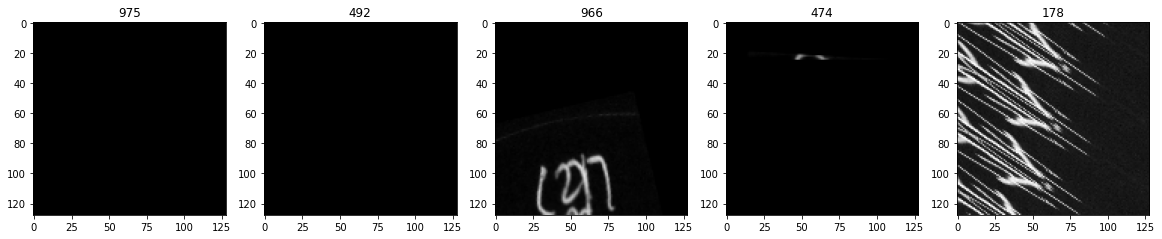

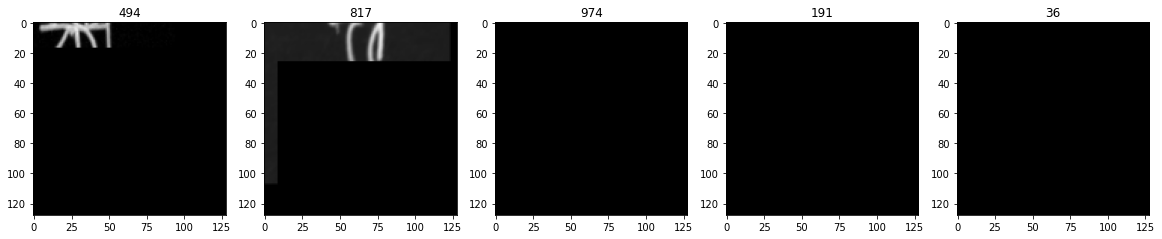

In [5]:
df_show = df_train.iloc[:1000]
dataset_show = BengaliDataset(df_show, data, list(range(df_show.shape[0])), 'train', 'train', transform=transforms_train)

from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, img_org, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(idx)

In [6]:
pretrained_dict = {f'efficientnet-b{i}': f for i, f in enumerate(sorted(glob.glob('bengali/efficientnet-pytorch/*pth')))}


sigmoid = torch.nn.Sigmoid()
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)

swish_layer = Swish_module()

def relu_fn(x):
    """ Swish activation function """
    return swish_layer(x)


class enet_3cg(nn.Module):

    def __init__(self, backbone, out_dim_1, out_dim_2):
        super(enet_3cg, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_dict[backbone]), strict=True)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        self.myfc_1 = nn.Linear(self.enet._fc.in_features, out_dim_2)
        self.activate = Swish_module()
        self.myfc_2 = nn.Linear(out_dim_2, out_dim_1)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out_2 = self.myfc_1(dropout(x))
            else:
                out_2 += self.myfc_1(dropout(x))
        out_2 /= len(self.dropouts)
        out_1 = self.myfc_2(self.activate(out_2))
        return out_1, out_2

## Loss func

In [7]:
def criterion(logits_1, logits_2, target, loss_weight=loss_weight, is_val=False):
    loss_1 = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], target[:, 1]) * loss_weight[1]
    loss_2 = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], target[:, 2]) * loss_weight[2]
    loss_3 = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], target[:, 3]) * loss_weight[3]
    if is_val:
        loss = (loss_1 + loss_2 + loss_3) / sum(loss_weight[1:])
    else:
        loss_0 = nn.CrossEntropyLoss()(logits_1, target[:, 0]) * loss_weight[0]
        loss = (loss_0 + loss_1 + loss_2 + loss_3) / sum(loss_weight)
    return loss

CE = nn.CrossEntropyLoss()
def criterion_mix(logits_1, logits_2, target, loss_weight=loss_weight):
    target, shuffled_target, lam = target

    loss_0 = nn.CrossEntropyLoss()(logits_1, target[:, 0]) * loss_weight[0]
    loss_1 = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], target[:, 1]) * loss_weight[1]
    loss_2 = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], target[:, 2]) * loss_weight[2]
    loss_3 = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], target[:, 3]) * loss_weight[3]

    loss = (loss_0 + loss_1 + loss_2 + loss_3) / sum(loss_weight)
    
    loss_0_mix = nn.CrossEntropyLoss()(logits_1, shuffled_target[:, 0]) * loss_weight[0]
    loss_1_mix = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], shuffled_target[:, 1]) * loss_weight[1]
    loss_2_mix = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], shuffled_target[:, 2]) * loss_weight[2]
    loss_3_mix = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], shuffled_target[:, 3]) * loss_weight[3]

    loss_mix = (loss_0_mix + loss_1_mix + loss_2_mix + loss_3_mix) / sum(loss_weight)

    return lam * loss + (1 - lam) * loss_mix


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

    
def cutmix(data, target, alpha, clip=[0.3, 0.7]):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), clip[0], clip[1])
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return data, targets

## train and val

In [8]:
def get_score(solution, submission):

    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[component].values
        y_pred_subset = submission[component].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2,1,1])
    return final_score


def train_epoch(loader, optimizer, mb):

    model.train()
    train_loss = []
    for (data, data_org, target) in progress_bar(loader, parent=mb):

        data, data_org, target = data.to(device), data_org.to(device), target.to(device)
        ### mixup & cutmix & cutout
        rand_p = np.random.rand()
        if rand_p <= 0.0:
            data, target = mixup(data_org, target, 1.)  # process from origin
            loss_func = criterion_mix
        elif 0.0 < rand_p <= 0.2:
            data, target = cutmix(data_org, target, 1.)  # process from origin
            loss_func = criterion_mix
        else:
            loss_func = criterion
        ###
        optimizer.zero_grad()
        logits_1, logits_2 = model(data)
        loss = loss_func(logits_1, logits_2, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-20:]) / min(len(train_loss), 20)
        mb.child.comment = 'loss: %.5f, smth: %.5f' % (loss_np, smooth_loss)
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    outputs = []
    LOGITS_1, LOGITS_2, LOGITS_M = [], [], []
    p1, p2, p3 = [], [], []
    masks = []
    acc, acc1, acc2, acc3 = 0.0,0.0,0.0,0.0

    with torch.no_grad():
        for (data, data_org, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits_1, logits_2 = model(data)

            loss = criterion(logits_1, logits_2, target, is_val=True)

            pred = logits_1.argmax(1).detach()
            pred1 = logits_2[:, :c1_dim].argmax(1).detach()
            pred2 = logits_2[:, c1_dim:c1_dim+c2_dim].argmax(1).detach()
            pred3 = logits_2[:, c1_dim+c2_dim:].argmax(1).detach()
            outputs.append(pred)
            p1.append(pred1)
            p2.append(pred2)
            p3.append(pred3)

            acc += (target[:, 0] == pred).sum().cpu().numpy()
            acc1 += (target[:, 1] == pred1).sum().cpu().numpy()
            acc2 += (target[:, 2] == pred2).sum().cpu().numpy()
            acc3 += (target[:, 3] == pred3).sum().cpu().numpy()
            
            if get_output:
                LOGITS_1.append(logits_1)
                LOGITS_2.append(logits_2)

            val_loss.append(loss.detach().cpu().numpy())

        val_loss = np.mean(val_loss)
        acc = acc / len(dataset_valid) * 100
        acc1 = acc1 / len(dataset_valid) * 100
        acc2 = acc2 / len(dataset_valid) * 100
        acc3 = acc3 / len(dataset_valid) * 100

    preds = torch.cat(outputs).cpu().numpy()
    solution = df_train.iloc[valid_idx]
    submission1 = df_label_map.iloc[preds]
    score1 = get_score(solution, submission1)
    
    submission2 = pd.DataFrame({
        'grapheme_root': torch.cat(p1).cpu().numpy(),
        'vowel_diacritic': torch.cat(p2).cpu().numpy(),
        'consonant_diacritic': torch.cat(p3).cpu().numpy(),
    })
    score2 = get_score(solution, submission2)

    if get_output:
        LOGITS_1 = torch.cat(LOGITS_1).cpu().numpy()
        LOGITS_2 = torch.cat(LOGITS_2).cpu().numpy()
        return LOGITS_1, LOGITS_2
    else:
        return val_loss, acc, acc1, acc2, acc3, score1, score2

In [9]:
n_fold = 5
record = [{'train_loss': [], 'val_loss': [], 'score1': [], 'score2': []} for x in range(n_fold)]

In [10]:
i_fold = fold
train_idx, valid_idx = np.where((df_train['fold'] != i_fold))[0], np.where((df_train['fold'] == i_fold))[0]

dataset_train = BengaliDataset(df_train, data, train_idx, 'train', 'train', transform=transforms_train)
dataset_valid = BengaliDataset(df_train, data, valid_idx, 'train', 'val', transform=transforms_val)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=None, num_workers=num_workers)

targets0 = df_train.loc[valid_idx]['grapheme_id'].values

model = enet_3cg(enet_type, out_dim_1=c0_dim, out_dim_2=c1_dim+c2_dim+c3_dim)
model = model.to(device)

max_score = 0
model_file = f'{kernel_type}_best_fold{i_fold}.pth'

print('Training All Layers...')
optimizer = optim.AdamW(model.parameters(), lr=init_lr)
# optimizer = apex.optimizers.FusedAdam(model.parameters(), lr=init_lr)
if use_amp:
    model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
mb = master_bar(range(1, n_epochs+1))
for epoch in mb:
    print(time.ctime(), 'Epoch:', epoch)
    scheduler_cosine.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer, mb)
    val_loss, acc, acc1, acc2, acc3, score1, score2 = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, acc1: {(acc1):.5f}, acc2: {(acc2):.5f}, acc3: {(acc3):.5f}, score1: {(score1):.6f}, score2: {(score2):.6f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if score1 >= max_score:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(max_score, score1))
        torch.save(model.state_dict(), model_file)
        max_score = score1

    record[i_fold]['train_loss'].append(np.mean(train_loss))
    record[i_fold]['val_loss'].append(val_loss)
    record[i_fold]['score1'].append(np.mean(score1))
    record[i_fold]['score2'].append(score2)

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_model_fold{i_fold}.pth'))

Training All Layers...


Sun Apr 19 01:07:07 2020 Epoch: 1


/home/pengfei/miniconda3/envs/xray/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-6-f886b4cd4d11>:14: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]
<ipython-input-8-521c432fe113>:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for (data, data_org, target) in tqdm(loader):



Sun Apr 19 01:25:52 2020 Epoch 1, lr: 0.0010000, train loss: 4.90027, val loss: 1.56021, acc: 17.78779, acc1: 29.46873, acc2: 82.88439, acc3: 86.33240, score1: 0.434233, score2: 0.360731
score2 (0.000000 --> 0.434233).  Saving model ...
Sun Apr 19 01:25:52 2020 Epoch: 2



Sun Apr 19 01:44:52 2020 Epoch 2, lr: 0.0009993, train loss: 4.39490, val loss: 0.73472, acc: 57.49851, acc1: 70.10058, acc2: 91.08992, acc3: 93.08405, score1: 0.733702, score2: 0.669279
score2 (0.434233 --> 0.733702).  Saving model ...
Sun Apr 19 01:44:53 2020 Epoch: 3



Sun Apr 19 02:03:35 2020 Epoch 3, lr: 0.0009973, train loss: 4.15843, val loss: 0.49238, acc: 74.27056, acc1: 80.11850, acc2: 94.15704, acc3: 95.20016, score1: 0.835491, score2: 0.831630
score2 (0.733702 --> 0.835491).  Saving model ...
Sun Apr 19 02:03:36 2020 Epoch: 4



Sun Apr 19 02:22:23 2020 Epoch 4, lr: 0.0009938, train loss: 4.07651, val loss: 0.39548, acc: 79.08285, acc1: 83.66112, acc2: 95.32713, acc3: 95.60098, score1: 0.864828, score2: 0.859182
score2 (0.835491 --> 0.864828).  Saving model ...
Sun Apr 19 02:22:23 2020 Epoch: 5



Sun Apr 19 02:41:19 2020 Epoch 5, lr: 0.0009891, train loss: 4.00060, val loss: 0.32224, acc: 83.36985, acc1: 87.21370, acc2: 95.67317, acc3: 95.91466, score1: 0.893790, score2: 0.876915
score2 (0.864828 --> 0.893790).  Saving model ...
Sun Apr 19 02:41:20 2020 Epoch: 6



Sun Apr 19 02:59:55 2020 Epoch 6, lr: 0.0009830, train loss: 3.94943, val loss: 0.34196, acc: 82.84704, acc1: 86.25025, acc2: 95.76778, acc3: 96.66650, score1: 0.883441, score2: 0.873735
Sun Apr 19 02:59:55 2020 Epoch: 7



Sun Apr 19 03:18:46 2020 Epoch 7, lr: 0.0009755, train loss: 3.91800, val loss: 0.26775, acc: 86.97222, acc1: 89.69080, acc2: 96.45738, acc3: 96.85820, score1: 0.916668, score2: 0.912778
score2 (0.893790 --> 0.916668).  Saving model ...
Sun Apr 19 03:18:46 2020 Epoch: 8



Sun Apr 19 03:36:48 2020 Epoch 8, lr: 0.0009668, train loss: 3.88738, val loss: 0.24981, acc: 89.16550, acc1: 90.87582, acc2: 96.72874, acc3: 96.95031, score1: 0.929878, score2: 0.913933
score2 (0.916668 --> 0.929878).  Saving model ...
Sun Apr 19 03:36:48 2020 Epoch: 9



Sun Apr 19 03:55:44 2020 Epoch 9, lr: 0.0009568, train loss: 3.87181, val loss: 0.21875, acc: 89.25264, acc1: 91.72227, acc2: 96.76359, acc3: 97.08723, score1: 0.930564, score2: 0.921590
score2 (0.929878 --> 0.930564).  Saving model ...
Sun Apr 19 03:55:44 2020 Epoch: 10



Sun Apr 19 04:14:43 2020 Epoch 10, lr: 0.0009455, train loss: 3.84739, val loss: 0.20451, acc: 90.14887, acc1: 92.46166, acc2: 97.17188, acc3: 97.45569, score1: 0.939211, score2: 0.932672
score2 (0.930564 --> 0.939211).  Saving model ...
Sun Apr 19 04:14:44 2020 Epoch: 11



Sun Apr 19 04:33:18 2020 Epoch 11, lr: 0.0009330, train loss: 3.84728, val loss: 0.20751, acc: 90.16879, acc1: 92.08823, acc2: 97.36855, acc3: 97.45071, score1: 0.937783, score2: 0.932061
Sun Apr 19 04:33:18 2020 Epoch: 12



Sun Apr 19 04:52:03 2020 Epoch 12, lr: 0.0009193, train loss: 3.83357, val loss: 0.20880, acc: 90.53724, acc1: 92.23013, acc2: 97.30880, acc3: 97.47560, score1: 0.938552, score2: 0.922418
Sun Apr 19 04:52:03 2020 Epoch: 13



Sun Apr 19 05:10:59 2020 Epoch 13, lr: 0.0009045, train loss: 3.79706, val loss: 0.19869, acc: 91.40609, acc1: 92.88986, acc2: 97.58763, acc3: 97.64987, score1: 0.946538, score2: 0.934245
score2 (0.939211 --> 0.946538).  Saving model ...
Sun Apr 19 05:10:59 2020 Epoch: 14



Sun Apr 19 05:29:11 2020 Epoch 14, lr: 0.0008886, train loss: 3.77265, val loss: 0.19015, acc: 91.56045, acc1: 93.09649, acc2: 97.40838, acc3: 97.66730, score1: 0.946264, score2: 0.939590
Sun Apr 19 05:29:11 2020 Epoch: 15



Sun Apr 19 05:48:05 2020 Epoch 15, lr: 0.0008716, train loss: 3.78093, val loss: 0.18224, acc: 91.61273, acc1: 93.17616, acc2: 97.75194, acc3: 97.71958, score1: 0.948127, score2: 0.943530
score2 (0.946538 --> 0.948127).  Saving model ...
Sun Apr 19 05:48:06 2020 Epoch: 16



Sun Apr 19 06:06:58 2020 Epoch 16, lr: 0.0008536, train loss: 3.75044, val loss: 0.17936, acc: 91.90400, acc1: 93.65664, acc2: 97.62746, acc3: 97.35610, score1: 0.947411, score2: 0.929657
Sun Apr 19 06:06:58 2020 Epoch: 17



Sun Apr 19 06:25:55 2020 Epoch 17, lr: 0.0008346, train loss: 3.75612, val loss: 0.18262, acc: 91.67745, acc1: 93.21848, acc2: 97.77933, acc3: 97.71211, score1: 0.946237, score2: 0.937492
Sun Apr 19 06:25:55 2020 Epoch: 18



Sun Apr 19 06:44:22 2020 Epoch 18, lr: 0.0008147, train loss: 3.72414, val loss: 0.16504, acc: 92.78779, acc1: 93.79606, acc2: 97.84903, acc3: 97.79675, score1: 0.954073, score2: 0.940095
score2 (0.948127 --> 0.954073).  Saving model ...
Sun Apr 19 06:44:23 2020 Epoch: 19



Sun Apr 19 07:03:17 2020 Epoch 19, lr: 0.0007939, train loss: 3.72212, val loss: 0.16735, acc: 92.86248, acc1: 93.85581, acc2: 97.96106, acc3: 97.75941, score1: 0.954387, score2: 0.942574
score2 (0.954073 --> 0.954387).  Saving model ...
Sun Apr 19 07:03:17 2020 Epoch: 20



Sun Apr 19 07:22:12 2020 Epoch 20, lr: 0.0007723, train loss: 3.71396, val loss: 0.16733, acc: 93.07658, acc1: 94.03505, acc2: 98.05069, acc3: 97.93368, score1: 0.954512, score2: 0.945029
score2 (0.954387 --> 0.954512).  Saving model ...
Sun Apr 19 07:22:13 2020 Epoch: 21



Sun Apr 19 07:40:37 2020 Epoch 21, lr: 0.0007500, train loss: 3.70358, val loss: 0.15442, acc: 93.62677, acc1: 94.34625, acc2: 98.28968, acc3: 98.09550, score1: 0.956871, score2: 0.947096
score2 (0.954512 --> 0.956871).  Saving model ...
Sun Apr 19 07:40:38 2020 Epoch: 22



Sun Apr 19 07:59:39 2020 Epoch 22, lr: 0.0007270, train loss: 3.68231, val loss: 0.15145, acc: 93.31309, acc1: 94.24417, acc2: 98.09799, acc3: 98.08554, score1: 0.958320, score2: 0.949401
score2 (0.956871 --> 0.958320).  Saving model ...
Sun Apr 19 07:59:40 2020 Epoch: 23



Sun Apr 19 08:18:23 2020 Epoch 23, lr: 0.0007034, train loss: 3.66702, val loss: 0.14997, acc: 93.76618, acc1: 94.63503, acc2: 98.24487, acc3: 98.01334, score1: 0.957992, score2: 0.949505
Sun Apr 19 08:18:23 2020 Epoch: 24



Sun Apr 19 08:37:16 2020 Epoch 24, lr: 0.0006792, train loss: 3.67314, val loss: 0.14298, acc: 94.05995, acc1: 94.80183, acc2: 98.36188, acc3: 98.30213, score1: 0.959946, score2: 0.953740
score2 (0.958320 --> 0.959946).  Saving model ...
Sun Apr 19 08:37:16 2020 Epoch: 25



Sun Apr 19 08:56:01 2020 Epoch 25, lr: 0.0006545, train loss: 3.64334, val loss: 0.13625, acc: 94.39106, acc1: 94.86656, acc2: 98.31956, acc3: 98.30960, score1: 0.963272, score2: 0.954410
score2 (0.959946 --> 0.963272).  Saving model ...
Sun Apr 19 08:56:02 2020 Epoch: 26



Sun Apr 19 09:15:05 2020 Epoch 26, lr: 0.0006294, train loss: 3.64870, val loss: 0.13505, acc: 94.48068, acc1: 94.63503, acc2: 98.47640, acc3: 98.35441, score1: 0.966067, score2: 0.956078
score2 (0.963272 --> 0.966067).  Saving model ...
Sun Apr 19 09:15:06 2020 Epoch: 27



Sun Apr 19 09:33:39 2020 Epoch 27, lr: 0.0006040, train loss: 3.63716, val loss: 0.13304, acc: 94.38608, acc1: 94.92880, acc2: 98.55357, acc3: 98.31707, score1: 0.964170, score2: 0.955375
Sun Apr 19 09:33:39 2020 Epoch: 28



Sun Apr 19 09:52:14 2020 Epoch 28, lr: 0.0005782, train loss: 3.63032, val loss: 0.12886, acc: 94.60516, acc1: 95.06323, acc2: 98.45150, acc3: 98.47142, score1: 0.966370, score2: 0.957609
score2 (0.966067 --> 0.966370).  Saving model ...
Sun Apr 19 09:52:15 2020 Epoch: 29



Sun Apr 19 10:11:08 2020 Epoch 29, lr: 0.0005523, train loss: 3.59776, val loss: 0.12625, acc: 94.84913, acc1: 95.16780, acc2: 98.61581, acc3: 98.43906, score1: 0.967977, score2: 0.959607
score2 (0.966370 --> 0.967977).  Saving model ...
Sun Apr 19 10:11:09 2020 Epoch: 30



Sun Apr 19 10:29:58 2020 Epoch 30, lr: 0.0005262, train loss: 3.60668, val loss: 0.12661, acc: 94.69727, acc1: 95.19269, acc2: 98.47391, acc3: 98.45150, score1: 0.966225, score2: 0.960036
Sun Apr 19 10:29:58 2020 Epoch: 31



Sun Apr 19 10:48:30 2020 Epoch 31, lr: 0.0005000, train loss: 3.58588, val loss: 0.12793, acc: 94.88150, acc1: 95.32215, acc2: 98.60586, acc3: 98.40669, score1: 0.967589, score2: 0.959285
Sun Apr 19 10:48:30 2020 Epoch: 32



Sun Apr 19 11:07:14 2020 Epoch 32, lr: 0.0004738, train loss: 3.55994, val loss: 0.12058, acc: 94.99353, acc1: 95.33957, acc2: 98.47889, acc3: 98.52619, score1: 0.967466, score2: 0.960103
Sun Apr 19 11:07:14 2020 Epoch: 33



Sun Apr 19 11:25:49 2020 Epoch 33, lr: 0.0004477, train loss: 3.54529, val loss: 0.12052, acc: 95.06074, acc1: 95.51882, acc2: 98.71042, acc3: 98.55855, score1: 0.967641, score2: 0.961345
Sun Apr 19 11:25:49 2020 Epoch: 34



Sun Apr 19 11:44:04 2020 Epoch 34, lr: 0.0004218, train loss: 3.56517, val loss: 0.11547, acc: 95.31219, acc1: 95.65575, acc2: 98.74278, acc3: 98.62826, score1: 0.970505, score2: 0.963688
score2 (0.967977 --> 0.970505).  Saving model ...
Sun Apr 19 11:44:04 2020 Epoch: 35



Sun Apr 19 12:02:59 2020 Epoch 35, lr: 0.0003960, train loss: 3.57200, val loss: 0.11417, acc: 95.32215, acc1: 95.75533, acc2: 98.72535, acc3: 98.54113, score1: 0.970025, score2: 0.963500
Sun Apr 19 12:02:59 2020 Epoch: 36



Sun Apr 19 12:21:37 2020 Epoch 36, lr: 0.0003706, train loss: 3.54595, val loss: 0.11391, acc: 95.41924, acc1: 95.68064, acc2: 98.66809, acc3: 98.50129, score1: 0.971661, score2: 0.963855
score2 (0.970505 --> 0.971661).  Saving model ...
Sun Apr 19 12:21:38 2020 Epoch: 37



Sun Apr 19 12:40:29 2020 Epoch 37, lr: 0.0003455, train loss: 3.53713, val loss: 0.11021, acc: 95.43916, acc1: 95.77026, acc2: 98.75772, acc3: 98.59341, score1: 0.970481, score2: 0.963787
Sun Apr 19 12:40:29 2020 Epoch: 38



Sun Apr 19 12:59:12 2020 Epoch 38, lr: 0.0003208, train loss: 3.52511, val loss: 0.10702, acc: 95.68811, acc1: 95.93457, acc2: 98.76519, acc3: 98.60586, score1: 0.971676, score2: 0.965428
score2 (0.971661 --> 0.971676).  Saving model ...
Sun Apr 19 12:59:13 2020 Epoch: 39



Sun Apr 19 13:17:58 2020 Epoch 39, lr: 0.0002966, train loss: 3.52196, val loss: 0.10966, acc: 95.76778, acc1: 95.89474, acc2: 98.85481, acc3: 98.74776, score1: 0.972621, score2: 0.965813
score2 (0.971676 --> 0.972621).  Saving model ...
Sun Apr 19 13:17:59 2020 Epoch: 40



Sun Apr 19 13:36:22 2020 Epoch 40, lr: 0.0002730, train loss: 3.52021, val loss: 0.10777, acc: 95.72047, acc1: 95.86736, acc2: 98.81249, acc3: 98.71540, score1: 0.972206, score2: 0.966093
Sun Apr 19 13:36:22 2020 Epoch: 41



Sun Apr 19 13:54:56 2020 Epoch 41, lr: 0.0002500, train loss: 3.52523, val loss: 0.10133, acc: 95.97441, acc1: 96.19349, acc2: 98.88966, acc3: 98.71788, score1: 0.973808, score2: 0.966929
score2 (0.972621 --> 0.973808).  Saving model ...
Sun Apr 19 13:54:57 2020 Epoch: 42



Sun Apr 19 14:13:56 2020 Epoch 42, lr: 0.0002277, train loss: 3.48947, val loss: 0.09928, acc: 95.95449, acc1: 96.12378, acc2: 98.90211, acc3: 98.78510, score1: 0.974835, score2: 0.966276
score2 (0.973808 --> 0.974835).  Saving model ...
Sun Apr 19 14:13:57 2020 Epoch: 43



Sun Apr 19 14:32:46 2020 Epoch 43, lr: 0.0002061, train loss: 3.48496, val loss: 0.09799, acc: 96.01922, acc1: 96.16610, acc2: 98.94941, acc3: 98.73282, score1: 0.974953, score2: 0.967856
score2 (0.974835 --> 0.974953).  Saving model ...
Sun Apr 19 14:32:46 2020 Epoch: 44



Sun Apr 19 14:51:41 2020 Epoch 44, lr: 0.0001853, train loss: 3.48726, val loss: 0.09740, acc: 96.14868, acc1: 96.20345, acc2: 98.88717, acc3: 98.70295, score1: 0.976011, score2: 0.967854
score2 (0.974953 --> 0.976011).  Saving model ...
Sun Apr 19 14:51:42 2020 Epoch: 45



Sun Apr 19 15:10:41 2020 Epoch 45, lr: 0.0001654, train loss: 3.47752, val loss: 0.09681, acc: 96.17606, acc1: 96.27066, acc2: 98.96186, acc3: 98.82494, score1: 0.975773, score2: 0.968279
Sun Apr 19 15:10:41 2020 Epoch: 46



Sun Apr 19 15:29:19 2020 Epoch 46, lr: 0.0001464, train loss: 3.47945, val loss: 0.09526, acc: 96.22585, acc1: 96.27315, acc2: 98.93448, acc3: 98.84236, score1: 0.975311, score2: 0.968248
Sun Apr 19 15:29:19 2020 Epoch: 47



Sun Apr 19 15:48:15 2020 Epoch 47, lr: 0.0001284, train loss: 3.45984, val loss: 0.09358, acc: 96.26319, acc1: 96.39514, acc2: 98.95937, acc3: 98.85730, score1: 0.976465, score2: 0.969711
score2 (0.976011 --> 0.976465).  Saving model ...
Sun Apr 19 15:48:16 2020 Epoch: 48



Sun Apr 19 16:06:55 2020 Epoch 48, lr: 0.0001114, train loss: 3.45025, val loss: 0.09300, acc: 96.24826, acc1: 96.31548, acc2: 98.95937, acc3: 98.86975, score1: 0.974902, score2: 0.968481
Sun Apr 19 16:06:55 2020 Epoch: 49



Sun Apr 19 16:25:45 2020 Epoch 49, lr: 0.0000955, train loss: 3.44817, val loss: 0.08941, acc: 96.37771, acc1: 96.38269, acc2: 98.98925, acc3: 98.88717, score1: 0.977017, score2: 0.969822
score2 (0.976465 --> 0.977017).  Saving model ...
Sun Apr 19 16:25:46 2020 Epoch: 50



Sun Apr 19 16:44:28 2020 Epoch 50, lr: 0.0000807, train loss: 3.44458, val loss: 0.08963, acc: 96.43248, acc1: 96.40012, acc2: 99.00667, acc3: 98.93696, score1: 0.976998, score2: 0.969838
Sun Apr 19 16:44:28 2020 Epoch: 51



Sun Apr 19 17:03:30 2020 Epoch 51, lr: 0.0000670, train loss: 3.44037, val loss: 0.08890, acc: 96.47730, acc1: 96.42750, acc2: 99.02410, acc3: 98.91207, score1: 0.977236, score2: 0.970402
score2 (0.977017 --> 0.977236).  Saving model ...
Sun Apr 19 17:03:31 2020 Epoch: 52



Sun Apr 19 17:22:28 2020 Epoch 52, lr: 0.0000545, train loss: 3.44543, val loss: 0.08910, acc: 96.46734, acc1: 96.52460, acc2: 99.04650, acc3: 98.92950, score1: 0.977443, score2: 0.970868
score2 (0.977236 --> 0.977443).  Saving model ...
Sun Apr 19 17:22:29 2020 Epoch: 53



Sun Apr 19 17:40:56 2020 Epoch 53, lr: 0.0000432, train loss: 3.45705, val loss: 0.08706, acc: 96.53953, acc1: 96.50966, acc2: 99.03655, acc3: 98.89215, score1: 0.977789, score2: 0.970201
score2 (0.977443 --> 0.977789).  Saving model ...
Sun Apr 19 17:40:56 2020 Epoch: 54



Sun Apr 19 17:59:51 2020 Epoch 54, lr: 0.0000332, train loss: 3.43820, val loss: 0.08770, acc: 96.54451, acc1: 96.54202, acc2: 99.03655, acc3: 98.93199, score1: 0.977630, score2: 0.970718
Sun Apr 19 17:59:51 2020 Epoch: 55



Sun Apr 19 18:18:34 2020 Epoch 55, lr: 0.0000245, train loss: 3.43621, val loss: 0.08803, acc: 96.52460, acc1: 96.57688, acc2: 99.03406, acc3: 98.91207, score1: 0.977846, score2: 0.970714
score2 (0.977789 --> 0.977846).  Saving model ...
Sun Apr 19 18:18:35 2020 Epoch: 56



Sun Apr 19 18:37:35 2020 Epoch 56, lr: 0.0000170, train loss: 3.41455, val loss: 0.08596, acc: 96.55198, acc1: 96.55945, acc2: 99.03904, acc3: 98.91705, score1: 0.977753, score2: 0.970578
Sun Apr 19 18:37:35 2020 Epoch: 57



Sun Apr 19 18:56:26 2020 Epoch 57, lr: 0.0000109, train loss: 3.41851, val loss: 0.08573, acc: 96.58186, acc1: 96.55447, acc2: 99.04899, acc3: 98.91705, score1: 0.978009, score2: 0.970724
score2 (0.977846 --> 0.978009).  Saving model ...
Sun Apr 19 18:56:27 2020 Epoch: 58



Sun Apr 19 19:15:19 2020 Epoch 58, lr: 0.0000062, train loss: 3.41325, val loss: 0.08478, acc: 96.56443, acc1: 96.56692, acc2: 99.04650, acc3: 98.91207, score1: 0.977833, score2: 0.970578
Sun Apr 19 19:15:19 2020 Epoch: 59



Sun Apr 19 19:34:25 2020 Epoch 59, lr: 0.0000027, train loss: 3.40452, val loss: 0.08600, acc: 96.58684, acc1: 96.56941, acc2: 99.05646, acc3: 98.92452, score1: 0.978065, score2: 0.970649
score2 (0.978009 --> 0.978065).  Saving model ...
Sun Apr 19 19:34:26 2020 Epoch: 60



Sun Apr 19 19:53:18 2020 Epoch 60, lr: 0.0000007, train loss: 3.42261, val loss: 0.08643, acc: 96.56194, acc1: 96.58932, acc2: 99.06393, acc3: 98.91705, score1: 0.977827, score2: 0.970741
